In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

,h14_id,h14_ind,h14_sn,h14_merkey,h_new,h14_cobf,p14_wsc,p14_wsl,p14_wgc,p14_wgl,...,wc14_64,wc14_65,wc14_5aq4,wc14_5aq5,wc14_5aq6,h14_pers_income1,h14_pers_income2,h14_pers_income3,h14_pers_income4,h14_pers_income5
0,2.0,1.0,1.0,20101.0,0.0,NaN,0.291589,0.291589,1307.764781,1307.764781,...,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,3.0,1.0,1.0,30101.0,0.0,NaN,0.419753,0.419753,1882.570960,1882.570960,...,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,4.0,1.0,1.0,40101.0,0.0,NaN,0.265263,0.265980,1189.691668,1192.908537,...,NaN,,NaN,NaN,NaN,NaN,1284.0,NaN,0.0,NaN
3,6.0,1.0,1.0,60101.0,0.0,NaN,0.494906,0.495941,2219.630833,2224.273816,...,1.0,.,2.0,4.0,4.0,2304.0,NaN,1800.0,0.0,NaN
4,6.0,1.0,1.0,60101.0,0.0,NaN,1.017935,1.017935,4565.389177,4565.389177,...,1.0,.,1.0,5.0,2.0,NaN,NaN,NaN,0.0,NaN


### 변수명 바꾸기

In [15]:
welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)  

## 9-2 성별에 따른 월급 차이 - 성별에 따라 월급이 다를까?

### 1. 성별 변수 검토

In [7]:
# 성별(sex)가 숫자 데이터인지 문자 데이터인지 확인
welfare['sex'].dtype

dtype('float64')

In [9]:
# 빈도 - 남자(6505명), 여자(7913명)
welfare['sex'].value_counts()

sex
2.0    7913
1.0    6505
Name: count, dtype: int64

### 2. 성별 변수 전처리
성별   
    1 : 남자  
    2 : 여자  
    9 : 모름/무응답  

In [10]:
# 이상치 검토
welfare['sex'].value_counts()

sex
2.0    7913
1.0    6505
Name: count, dtype: int64

성별(sex)에 대한 값으로 1(남자)과 2(여자)만 있고 무응답/모름에 해당하는 9 값이 없음. 따라서 이상치(이상한 값)가 없다고 볼 수 있음. 그래서 별도의 이상치 처리 과정이 필요하지 않음

현 데이터(프레임)은 성별을 1과 2로 표현하고 있는데, 1을 'male'로 2를 'female'로 변경하겠음

In [16]:
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')
# 결과 확인
welfare['sex'].value_counts()

sex
female    7913
male      6505
Name: count, dtype: int64

<Axes: xlabel='sex', ylabel='count'>

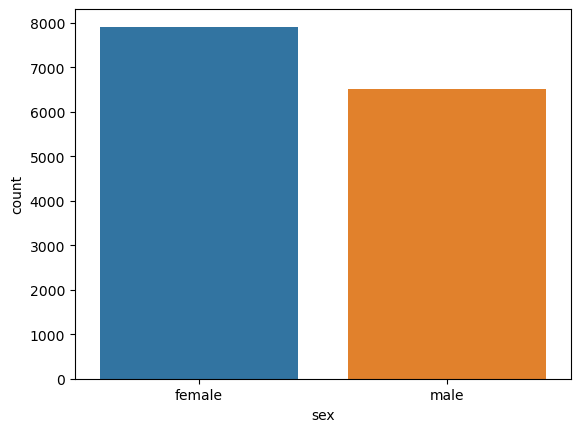

In [17]:
# 빈도를 막대 그래프로 표현
sns.countplot(data=welfare, x = 'sex')

---

### 1. 월급 변수 검토

In [18]:
welfare['income'].dtype

dtype('float64')

In [19]:
welfare['income'].describe()

count    4534.000000
mean      268.455007
std       198.021206
min         0.000000
25%       150.000000
50%       220.000000
75%       345.750000
max      1892.000000
Name: income, dtype: float64

<Axes: xlabel='income', ylabel='Count'>

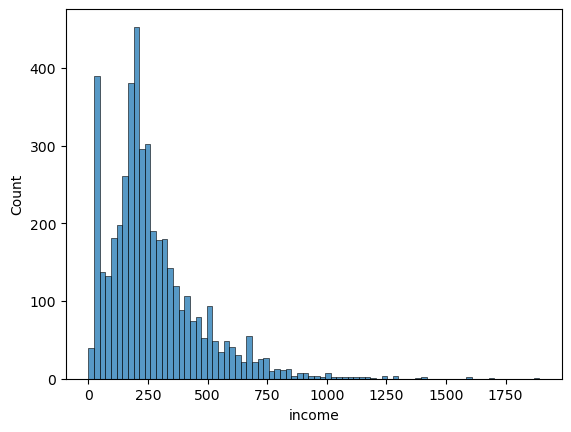

In [20]:
sns.histplot(data=welfare, x = 'income')

### 월급 변수 전처리

In [23]:
# income 변수의 값은 "일한 달의 평균 임금(단위는 만원)", 모름/무응답의 경우 9999
welfare['income'].describe()

count    4534.000000
mean      268.455007
std       198.021206
min         0.000000
25%       150.000000
50%       220.000000
75%       345.750000
max      1892.000000
Name: income, dtype: float64

모름 또는 무응답이 포함되었다면 최대값(max)은 9999일 것임. 그러나 최대값이 1892인 것으로 봤을 때, 모름/무응답에 해당하는 경우는 없음

In [25]:
#결측치 확인
welfare['income'].isna().sum()

9884

- 위 코드의 실행 결과는 9884임. 즉 결측치가 9884개 있음.  
- 간략 통계를 통해 월급의 최소값이 0인 경우가 있고 결측치가 9884개가 있는데 이를 어떻게 해석할 것인지는 생각을 해봐야할 것으로 보임.  
- 일단 결측치가 9884인 것은 직업이 없어서 해당 데이터가 공란(결측치)인 것으로 간주하겠음

### 성별에 따른 월급 차이 분석

In [29]:
sex_income = welfare.dropna(subset =['income']) \
                    .groupby('sex', as_index=False) \
                    .agg(mean_income = ('income', 'mean'))
sex_income

,sex,mean_income
0,female,186.293096
1,male,349.037571


월급(income) 평균이 여자는 약 186만원이고 남자는 약 349만원임을 알 수 있음. 남성이 여성 보다 약 163만원 더 많음

### 그래프 만들기

<Axes: xlabel='sex', ylabel='mean_income'>

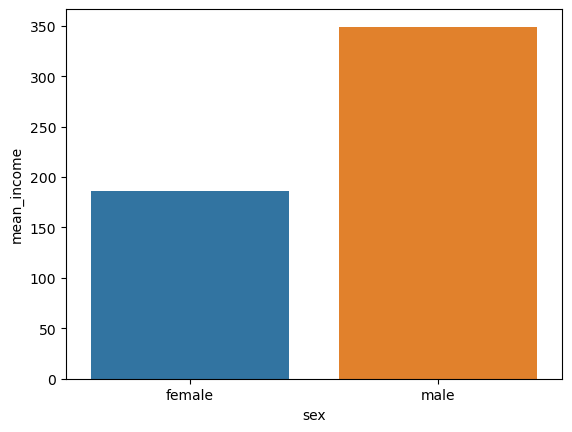

In [32]:
sns.barplot(data=sex_income, x = 'sex', y='mean_income')

---

## 코드 정리

<Axes: xlabel='sex', ylabel='mean_income'>

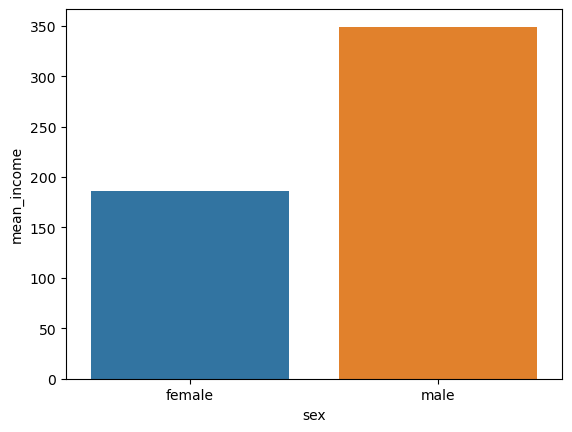

In [35]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

# 변수명 바꾸기
welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'p1402_8aq1' : 'income'         # 일을 한 달의 월 평균 임금[단위는 만원]
    }
)  

# 변수 검토 및 전처리
# 특이 사항 없어서 생략하고 성별(sex)의 값 1, 2를 'male'과 'female'로 변경
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')

# 성별에 따른 월급 차이 분석
sex_income = welfare.dropna(subset =['income']) \
                    .groupby('sex', as_index=False) \
                    .agg(mean_income = ('income', 'mean'))

# 그래프로 시각화
sns.barplot(data=sex_income, x = 'sex', y='mean_income')

## 9-3 나이와 월급의 관계 - 몇 살 때 월급을 가장 많이 받을까?

### 변수 검토하기
나이와 월급(income)을 기반으로 분석을 해야겠습니다. 월급(income) 변수 대해서는 이전 분석에서 살펴 보았고 특이사항이 없었습니다. 
그럼 나이에 대해 변수 검토부터 시작하려고 합니다. 그런데 주어진 데이터(프레임)에는 나이 변수가 없습니다. 나이와 관계된 출생년도(birth) 변수를 검토하고 출생년도(birth) 변수를 근거로 나이(age) (파생)변수를 생성할 생각입니다.

In [37]:
raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()
welfare.head()

# 변수명 바꾸기
welfare = welfare.rename(
    columns = {
        'h14_g4'     : 'birth',         # 태어난 년도
        'p1402_8aq1' : 'income'         # 일을 한 달의 월 평균 임금[단위는 만원]
    }
)  

### 변수 살펴 보기

In [38]:
welfare['birth'].dtypes

dtype('float64')

In [42]:
welfare['birth'].describe()

count    14418.000000
mean      1969.280205
std         24.402250
min       1907.000000
25%       1948.000000
50%       1968.000000
75%       1990.000000
max       2018.000000
Name: birth, dtype: float64

<Axes: xlabel='birth', ylabel='Count'>

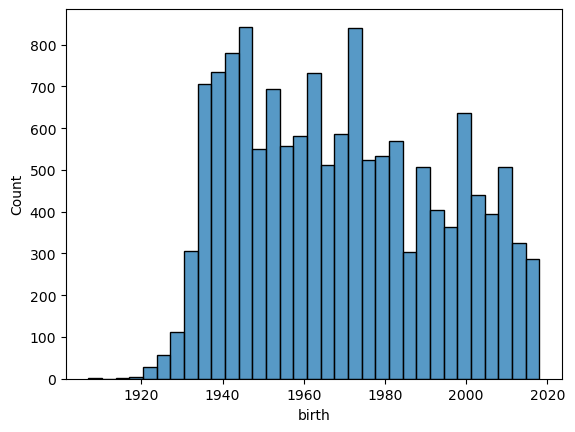

In [41]:
sns.histplot(data=welfare, x='birth')

### 전처리 

In [43]:
# birth의 값 범위는 1900~2014이며 모름/무응답은 9999임
# 아래 코드의 출력 결과를 보면 birth의 값 범위를 벗어난 데이터가 있음. max = 2018. 이 데이터는 정상으로 간주하겠음. 따라서 이상치가 없다고 판단!
welfare['birth'].describe()

count    14418.000000
mean      1969.280205
std         24.402250
min       1907.000000
25%       1948.000000
50%       1968.000000
75%       1990.000000
max       2018.000000
Name: birth, dtype: float64

In [44]:
# 결측치 조사
welfare['birth'].isna().sum()

0

### 파생변수 만들기
출생년도(birth) 변수를 이용하여 나이 값을 갖는 파생 변수 age를 만들겠음
주어진 데이터는 2019년에 조사가 진행되었음으로 2019년에서 태어난 연도를 빼면 나이가 됨(맞나요?)

In [73]:
welfare = welfare.assign( age = 2019-welfare['birth'] )
welfare['age'].describe()

count    14418.000000
mean        49.719795
std         24.402250
min          1.000000
25%         29.000000
50%         51.000000
75%         71.000000
max        112.000000
Name: age, dtype: float64

112살? 와우~

<Axes: xlabel='age', ylabel='Count'>

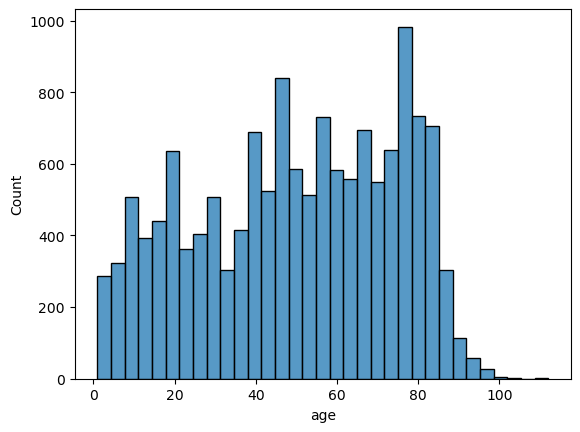

In [48]:
sns.histplot(data=welfare, x='age')

### 나이와 월급의 관계 분석하기

#### 나이에 따른 월급 평균표 만들기

In [74]:
age_income = welfare.dropna(subset=['income']) \
                    .groupby('age') \
                    .agg(mean_income = ('income', 'mean'))
age_income.head()

,mean_income
age,
18.0,162.000000
19.0,121.333333
20.0,136.400000
21.0,123.666667
22.0,179.676471


#### 그래프로 시각화 

<Axes: xlabel='age', ylabel='mean_income'>

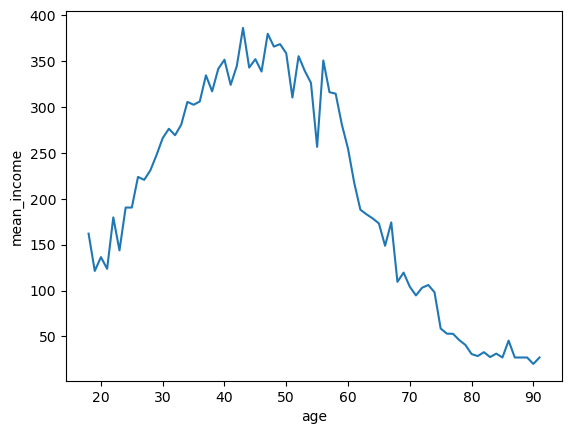

In [53]:
sns.lineplot(data=age_income, x='age', y='mean_income')

출력된 그래프를 보면 20대 초반에 월급을 150만원 가량 받고 이후 지속해서 증가하는 추세를 보입니다. 40대에서 350만원 가량으로 가장 많이 받고 이후 지속적으로 감소하다가 60대 후반부터는 20대 보다 낮은 월급을 받습니다.  
(60대 이후 평균 월급이 매우 낮아지는 것이 문제이지만 이 평균 월급은 월급을 받는 분들의 월급을 대상으로 구한 월급입니다. 못 받는 분들은?)

## 연렬대에 따른 월급 차이 - 어떤 연령대의 월급이 가장 많을까?

### Do it! - 연련대 변수 검토 및 전처리 하기

#### 파생변수 만들기 - 연령대

In [55]:
# 나이 변수 살펴보기
welfare['age'].head()

0    74.0
1    71.0
2    77.0
3    57.0
4    56.0
Name: age, dtype: float64

In [75]:
# 연령대 변수 만들기
welfare = welfare.assign(ageg = np.where(welfare['age'] < 30, 'young', 
                                         np.where(welfare['age'] <= 59, 'middle', 'old')))
welfare['ageg'].value_counts()

ageg
old       5743
middle    5066
young     3609
Name: count, dtype: int64

<Axes: xlabel='ageg', ylabel='count'>

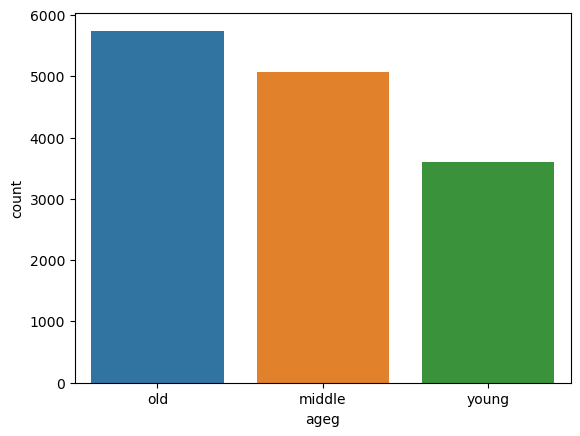

In [57]:
# 빈도 막대 그래프 만들기
sns.countplot(data=welfare, x='ageg')

### Do it! 연령대에 따른 월급 차이 분석하기

#### 1. 연령대별 월급 평균표 만들기

In [76]:
ageg_income = welfare.dropna(subset=['income']) \
                     .groupby('ageg', as_index=False) \
                     .agg(mean_income = ('income', 'mean'))
ageg_income

,ageg,mean_income
0,middle,329.737610
1,old,126.260302
2,young,202.595278


#### 2. 그래프로 시각화 하기

<Axes: xlabel='ageg', ylabel='mean_income'>

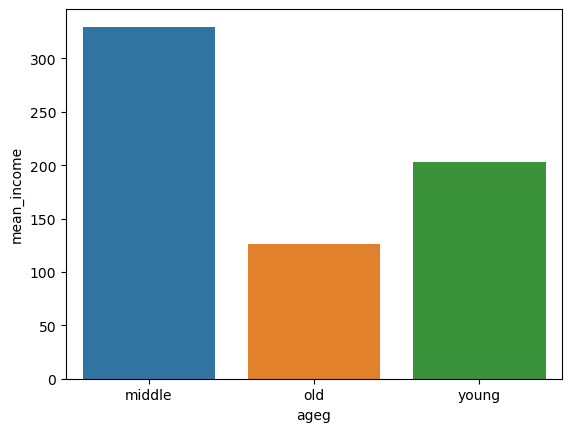

In [63]:
sns.barplot(data=ageg_income, x = 'ageg', y='mean_income')

막대 그래프 정렬 순서는 그래프를 만드는데 사용한 데이터프레임의 행 순서에 따라 정해짐.  
초년, 중년, 노년층 순으로 막대를 정렬하도록 order에 순서를 지정하겠음

<Axes: xlabel='ageg', ylabel='mean_income'>

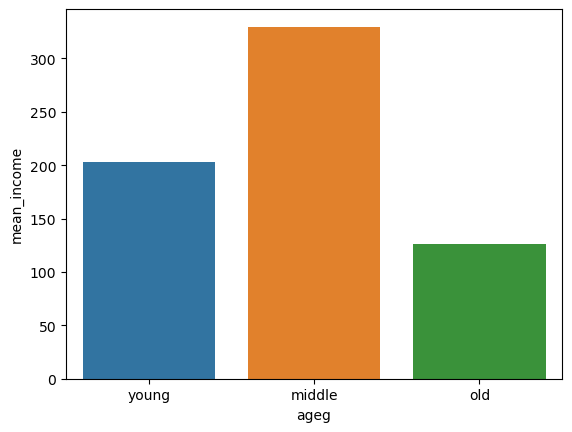

In [64]:
sns.barplot(data=ageg_income, x = 'ageg', y='mean_income', order=['young', 'middle', 'old'])

#### 3.분석 결과
출력된 표와 그래프를 보면 중년층이 330만원 정도의 가장 많은 월급을 받으며 노년층의 월급은 126만원으로 초년층이 받는 202만원 보다 적습니다.  

## 9-5 연령대 및 성별 월급 차이 - 성별 월급 차이는 연령대별로 다를까?

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns

raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()

welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)

# 변수명 변경
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')

# 파생 변수 만들기
welfare = welfare.assign( age = 2019-welfare['birth'] )

# 연령대 변수 만들기
welfare = welfare.assign(ageg = np.where(welfare['age'] < 30, 'young', 
                                         np.where(welfare['age'] <= 59, 'middle', 'old')))

### Do it! - 연령대 및 성별 월급 차이 분석하기

#### 1. 연령대 및 성별 월급 평균표 만들기
성별 월급 차이가 연령대별로 다른지 알아보기 위해 '연령대 및 성별에 따른 월급 평균표'를 만들겠습니다.

In [80]:
sex_income = welfare.dropna(subset=['income']) \
                    .groupby(['ageg', 'sex'], as_index=False) \
                    .agg(mean_income = ('income', 'mean'))
sex_income

,ageg,sex,mean_income
0,middle,female,229.026677
1,middle,male,410.602203
2,old,female,84.324653
3,old,male,183.909308
4,young,female,193.764706
5,young,male,215.953390


#### 2. 그래프로 시각화 하기
x축에는 ageg를 지정하고 막대 색깔은 성별에 따라 다드로도록 hue에 'sex'를 지정, 축 순서는 order을 이용해서 연령대 순으로 설정

<Axes: xlabel='ageg', ylabel='mean_income'>

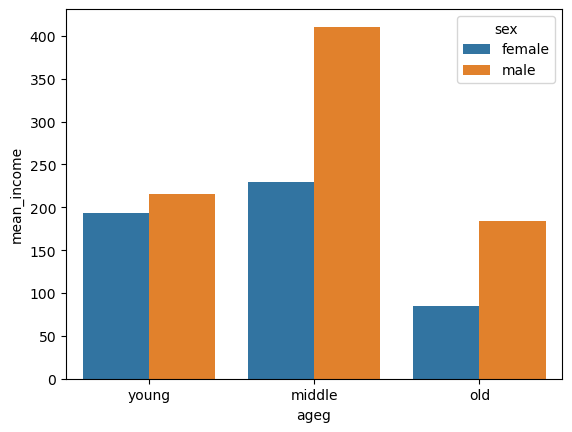

In [83]:
sns.barplot(data=sex_income, x='ageg', y='mean_income', hue = 'sex', order=['young', 'middle', 'old'])

앞 절에서 연령대별 월급을 분석할 때 노년층이 초년층보다 월급을 적게 받는 것으로 나타났습니다. 그런데 연령대와 성별로 나눈 이번 분석 결과를 보면 노년층이 초년층보다 월급을 적게 적게 받는 현상은 여성에서 두드러지게 나타납니다. 또한 중년층이 초년층보다 월급을 더 많이 받는 현상도 주로 남성에서 나타나고 여성은 차이가 크지 않습니다.

### Do it! - 나이 및 성별 월급 차이 분석하기

이번에는 연령대별로 구분하지 않고 '나이 및 성별 월급 평균표'를 만들어 선 그래프로 표현하겠습니다. 
그래프에서 성별에 따라 선 색깔이 다르도록 hue에 'sex'를 할당

In [85]:
sex_age = welfare.dropna(subset=['income']) \
                 .groupby(['age', 'sex'], as_index=False) \
                 .agg(mean_income = ('income', 'mean'))
sex_age.head()

,age,sex,mean_income
0,18.0,male,162.000000
1,19.0,female,87.666667
2,19.0,male,155.000000
3,20.0,female,124.000000
4,20.0,male,186.000000


<Axes: xlabel='age', ylabel='mean_income'>

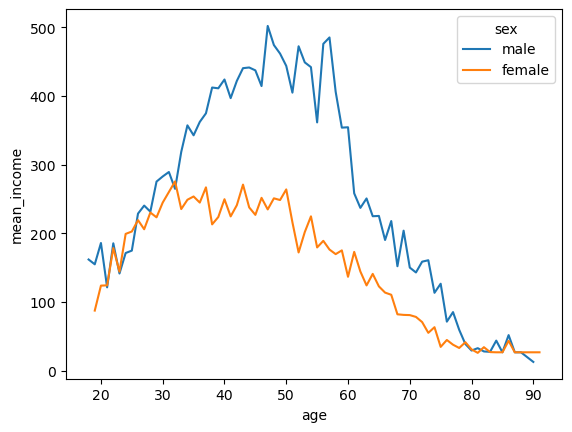

In [86]:
# 선 그래프 만들기
sns.lineplot(data=sex_age, x='age', y='mean_income', hue='sex')

위 그래프를 읽어 보면, 
- 남성의 월급은 50세 전후까지 증가하다가 이후 급격하게 감소하는 반면 여성은 30세 초반까지 약간 증가하다가 이후로는 완만하게 감소합니다. 
- 성별 월급 격차는 30대 중반부터 벌어지다가 50대에 가장 크게 벌어지고 이후 점점 줄어들어 
- 80대가 되면 비슷한 수준이 됩니다.

## 9-6 직업별 월급 차이 - 어떤 직업이 월급을 가장 많이 받을까?

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns

raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()

welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)

### Do it! - 직업 변수 검토 및 전처리하기

#### 1. 변수 검토하기
변수 code_job의 값은 '직업 코드'를 의미합니다. 복지패널 데이터에서 직업 정보는 직업 코드로 기록되어 있습니다. 
Koweps_Codebook_2009 파일의 '직종코드' 쉬트에서 각각의 직업 코드가 어떤 직업인지 확인할 수 있습니다. 

In [88]:
welfare['code_job'].dtypes

dtype('float64')

In [89]:
welfare['code_job'].value_counts()

code_job
611.0    962
941.0    391
521.0    354
312.0    275
873.0    236
        ... 
112.0      2
784.0      2
423.0      1
861.0      1
872.0      1
Name: count, Length: 150, dtype: int64

#### 2.전처리하기
코드북의 직업분류코드 목록을 이용해 직업 이름을 나타낼 변수를 만들겠습니다. 먼저 Koweps_Codebook_2019.xlsx 파일의 '직종코드' 시트에 있는 직업분류코드 목록을 불러온 다음 살펴보겠습니다. 

In [160]:
list_job = pd.read_excel('Koweps_Codebook_2019.xlsx', sheet_name='직종코드')
list_job.head()

,code_job,job
0,111,의회 의원∙고위 공무원 및 공공단체 임원
1,112,기업 고위 임원
2,121,행정 및 경영 지원 관리자
3,122,마케팅 및 광고∙홍보 관리자
4,131,연구∙교육 및 법률 관련 관리자


In [91]:
list_job.shape

(156, 2)

**`df.merge()`를 이용해 `list_job`을 `welfare`에 결합** 하겠습니다. `welfare`와 `list_job`에 공통으로 들어 있는 `code_job` 변수를 기준으로 결합하면 됩니다.

In [161]:
#welfare에 list_job 결합하기
welfare = welfare.merge(list_job, how='left', on='code_job')

welfare의 code_job과 job 변수 일부를 출력해 잘 결합되었는지 확인하겠습니다. 출력할 때 직업이 결측치인 행은 제외하겠습니다.

In [162]:
# welfare.dropna(subset=['code_job']).head()
welfare.dropna(subset=['code_job'])[['code_job', 'job']].head()       

,code_job,job
2,762.0,전기공
3,855.0,금속기계 부품 조립원
7,941.0,청소원 및 환경미화원
8,999.0,기타 서비스 관련 단순 종사자
14,312.0,경영 관련 사무원


### Do it! - 직업별 월급 차이 분석하기

#### 1. 직업별 월급 평균표 만들기

In [163]:
job_income = welfare.dropna(subset=['job', 'income']) \
                    .groupby('job', as_index=False) \
                    .agg(mean_income = ('income', 'mean'))
job_income.head()

,job,mean_income
0,가사 및 육아 도우미,92.455882
1,간호사,265.219178
2,감정∙기술영업및중개관련종사자,391.000000
3,건물 관리원 및 검표원,168.375000
4,건설 및 광업 단순 종사자,261.975000


In [169]:
# job_income.sort_values('mean_income')
# job_income.sort_values('mean_income', ascending=False).head()

#### 2. 그래프 만들기

##### (1) 월급이 많은 직업

In [108]:
top10 = job_income.sort_values('mean_income', ascending=False).head(10)
top10

,job,mean_income
98,의료 진료 전문가,781.000000
60,법률 전문가,776.333333
140,행정 및 경영 지원 관리자,771.833333
63,보험 및 금융 관리자,734.750000
110,재활용 처리 및 소각로 조작원,688.000000
131,컴퓨터 하드웨어 및 통신공학 전문가,679.444444
24,기계∙로봇공학 기술자 및 시험원,669.166667
6,건설∙전기 및 생산 관련 관리자,603.083333
120,제관원 및 판금원,597.000000
100,의회 의원∙고위 공무원 및 공공단체 임원,580.500000


한글로된 데이터(변수 job의 값)가 그래프에 출력될 수 있도록 폰트 설정을 하겠습니다.

In [170]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.family':'Malgun Gothic'})

<Axes: xlabel='mean_income', ylabel='job'>

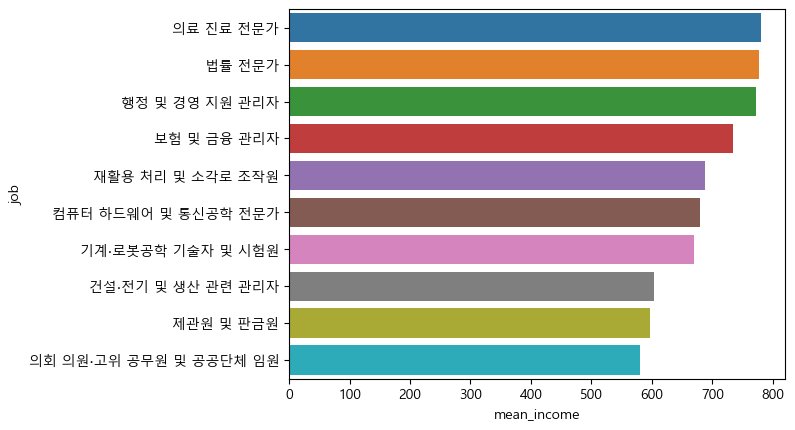

In [171]:
# 막대 그래프 만들기
sns.barplot(data=top10, y = 'job', x='mean_income')

<Axes: xlabel='job', ylabel='mean_income'>

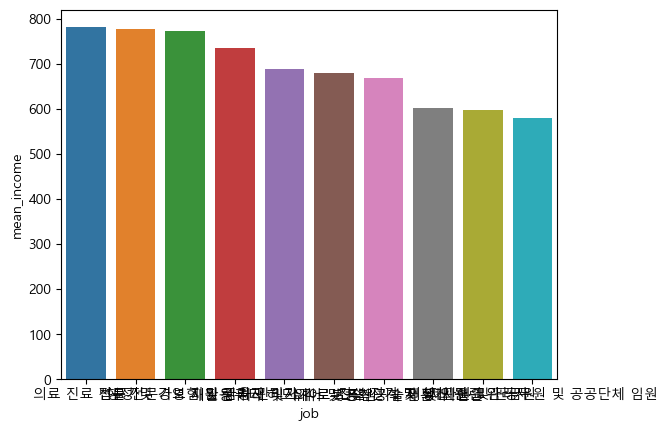

In [172]:
sns.barplot(data=top10, x = 'job', y='mean_income')

##### (2) 월급이 적은 직업

In [173]:
bottom10 = job_income.sort_values('mean_income').head(10)

<Axes: xlabel='mean_income', ylabel='job'>

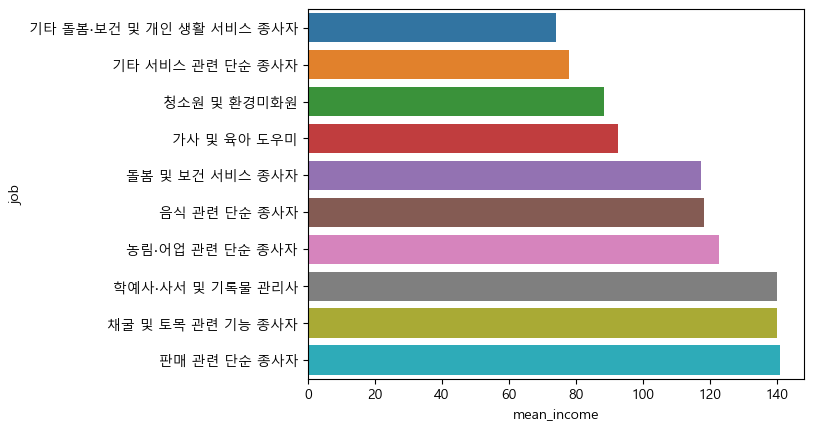

In [174]:
sns.barplot(data=bottom10, y = 'job', x='mean_income')

[(0.0, 800.0)]

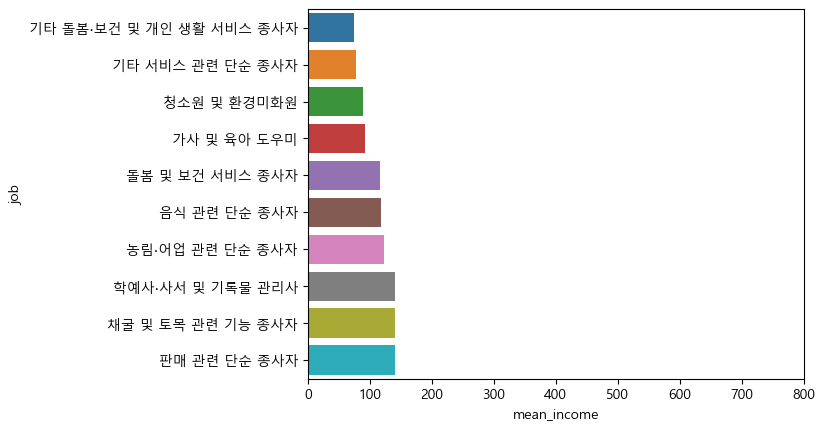

In [118]:
sns.barplot(data=bottom10, y = 'job', x='mean_income')\
   .set(xlim=[0, 800])

[(0.0, 800.0)]

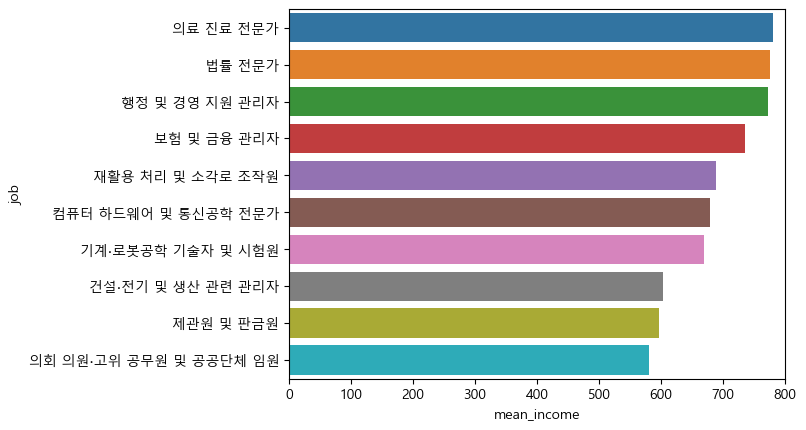

In [119]:
sns.barplot(data=top10, y = 'job', x='mean_income')\
   .set(xlim=[0, 800])

## 9-7 성별 직업 빈도 - 성별로 어떤 직업이 가장 많을까?
성별에 따라 다른 직업을 선택하는 경향이 있습니다. 성별에 따라 어떤 직업이 많은지 분석해 보겠습니다.  

In [179]:
import pandas as pd
import numpy as np
import seaborn as sns

raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()

welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)


# 변수명 변경
welfare['sex'] = np.where(welfare['sex'] == 1, 'male', 'female')

# 직종 코드에 대한 직업(job) 데이터 로드
list_job = pd.read_excel('Koweps_Codebook_2019.xlsx', sheet_name='직종코드')
# welfare에 list_job 결합하기
welfare = welfare.merge(list_job, how='left', on='code_job')

### Do it! - 성별 직업 빈도 분석하기

성별 변수는 8-2절에서, 직업 변수는 9-6절에서 전처리 작업을 완료했으니 생략하고 성별과 직업의 관계를 분석하겠습니다.

#### 1. 성별 직업 빈도표 만들기

In [178]:
# 남성 직업 빈도 상위 10개 추출
job_male = welfare.dropna(subset=['job']) \
                  .query('sex=="male"') \
                  .groupby('job', as_index=False) \
                  .agg(n = ('job', 'count')) \
                  .sort_values('n', ascending=False) \
                  .head(10)
job_male

,job,n
107,작물 재배 종사자,486
104,자동차 운전원,230
11,경영 관련 사무원,216
46,매장 판매 종사자,142
89,영업 종사자,113
127,청소원 및 환경미화원,109
4,건설 및 광업 단순 종사자,96
120,제조 관련 단순 종사자,80
3,건물 관리원 및 검표원,79
141,행정 사무원,74


In [132]:
# 여성 직업 빈도 상위 10개 추출
job_female = welfare.dropna(subset=['job']) \
                  .query('sex=="female"') \
                  .groupby('job', as_index=False) \
                  .agg(n = ('job', 'count')) \
                  .sort_values('n', ascending=False) \
                  .head(10)
job_male

,job,n
107,작물 재배 종사자,486
104,자동차 운전원,230
11,경영 관련 사무원,216
46,매장 판매 종사자,142
89,영업 종사자,113
127,청소원 및 환경미화원,109
4,건설 및 광업 단순 종사자,96
120,제조 관련 단순 종사자,80
3,건물 관리원 및 검표원,79
141,행정 사무원,74


#### 2. 그래프 만들기

[(0.0, 500.0)]

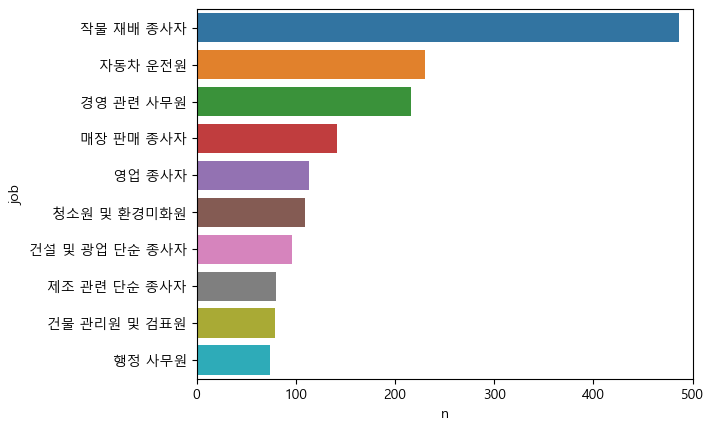

In [133]:
sns.barplot(data=job_male, y='job', x = 'n').set(xlim=[0, 500])

[(0.0, 500.0)]

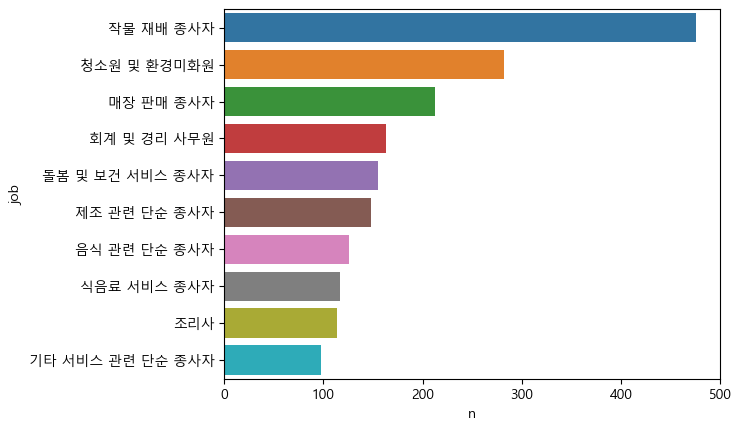

In [134]:
sns.barplot(data=job_female, y='job', x = 'n').set(xlim=[0, 500])

## 9-8 종교 유무에 따른 이혼율 - 종교가 있으면 이혼을 덜 할까?
종교가 있으면 이혼을 덜 할까요? 종교가 있는 사람이 종교가 없는 사람보다 이혼을 덜 하는지 분석해 보겠습니다. 먼저 '종교', '혼인 상태' 두 변수를 검토하고 전처리한 다음 종교와 이혼율의 관계를 분석하겠습니다. 

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns

raw_welfare = pd.read_spss('Koweps_hpwc14_2019_beta2.sav')
welfare = raw_welfare.copy()

welfare = welfare.rename(
    columns = {
        'h14_g3'     : 'sex',             # 1: 남자, 2: 여자
        'h14_g4'     : 'birth',           # 태어난 년도
        'h14_g10'    : 'marriage_type',
        'h14_g11'    : 'religion',
        'p1402_8aq1' : 'income',         # 일을 한 달의 월 평균 임금[단위는 만원]
        'h14_eco9'   : 'code_job', 
        'h14_reg7'   : 'code_region' 
    }
)

---

### Do it! - 종교 변수 검토 및 전처리하기

#### 1. 변수 검토

In [144]:
welfare['religion'].dtypes

dtype('float64')

In [145]:
welfare['religion'].value_counts()

religion
2.0    7815
1.0    6603
Name: count, dtype: int64

#### 2. 전처리하기

In [146]:
# 종교 유무에 이름 부여
welfare['religion'] = np.where(welfare['religion'] == 1, 'yes', 'no')

# 빈도 구하기
welfare['religion'].value_counts()

religion
no     7815
yes    6603
Name: count, dtype: int64

<Axes: xlabel='religion', ylabel='count'>

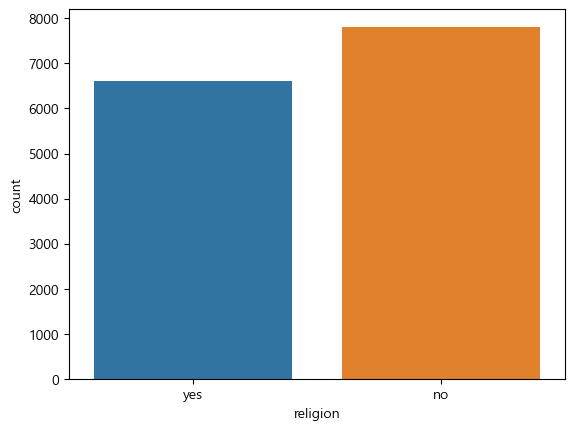

In [147]:
# 막대 그래프 그리기
sns.countplot(data=welfare, x='religion')

### Do it! - 혼인 상태 변수 검토 및 전처리하기
혼인 상태를 나타내는 `marriage_type`을 검토하고 전처리하겠습니다.

#### 1. 변수 검토하기

In [149]:
welfare['marriage_type'].dtypes

dtype('float64')

In [150]:
welfare['marriage_type'].value_counts()

marriage_type
1.0    7190
5.0    2357
0.0    2121
2.0    1954
3.0     689
4.0      78
6.0      29
Name: count, dtype: int64

#### 2.파생변수 만들기 - 이혼 여부
코드북의 '혼인 상태' 변수 항복을 보면 배우자가 있으면 1, 이혼했으면 3으로 입력되어 있습니다. 이 값을 이용해 이혼 여부를 나타내는 변수를 만들겠습니다.

|값|내용|
|:-:|:-:|
|0|비해당(18세 미만)|
|1|유배우|
|2|사별|
|3|이혼|
|4|별거|
|5|미혼(18세 이상, 미혼모 포함)|
|6|기타(사망 등)|

강사의 말 - "6 기타(사망 등)"은... 뭐죠? 사망이면 '사별'로 분류되어야 하는 거 아닌가요?



In [151]:
# 이혼 여부 변수 만들기
welfare['marriage'] = np.where(welfare['marriage_type'] == 1, 'mariage', 
                               np.where(welfare['marriage_type'] == 3, 'divorce', 'etc'))

In [153]:
# 이혼 여부별 빈도
n_divorce = welfare.groupby('marriage', as_index=False) \
                   .agg(n = ('marriage', 'count'))
n_divorce

,marriage,n
0,divorce,689
1,etc,6539
2,mariage,7190


<Axes: xlabel='marriage', ylabel='n'>

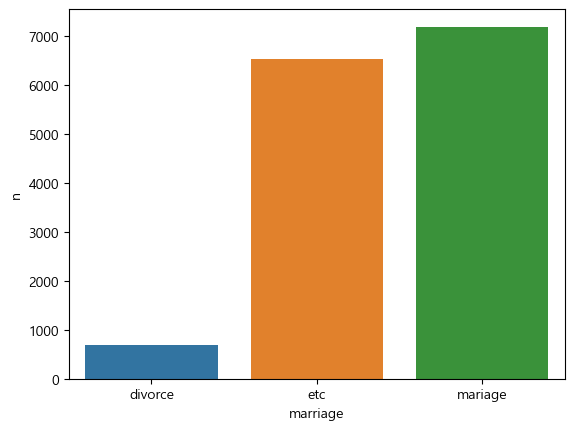

In [154]:
# 막대 그래프 만들기
sns.barplot(data=n_divorce, x='marriage', y='n')

출력한 표와 그래프를 보면 결혼 상태(`marriage`)인 사람은 7,190명, 이혼(`divorce`)한 사람은 689명입니다. 둘 중 어디에도 속하지 않아 `etc`로 분류된 사람은 6,539명입니다. `etc`에 포함된 사람은 분석 대상이 아니므로 이후 작업에서 제외하겠습니다. 

### Do it! - 종교 유무에 따른 이혼율 분석하기

#### 1.종교 유무에 따른 이혼율표 만들기
종교 유무에 따른 이혼율표를 만들겠습니다. 먼저 marriage가 'etc'인 경우를 제외하고 '종교 유무 및 이혼 여부별 비율'을 구하겠습니다. `value_counts()`에 `normalize=True`를 전달하면 비율이 구해집니다.

In [156]:
rel_div = welfare.query('marriage != "etc"') \
                 .groupby('religion', as_index=False) \
                 ['marriage'] \
                 .value_counts(normalize = True)
rel_div

,religion,marriage,proportion
0,no,mariage,0.905045
1,no,divorce,0.094955
2,yes,mariage,0.920469
3,yes,divorce,0.079531


#### 2.그래프 만들기
이혼에 해당하는 값만 추출한 다음 `proportion`을 백분율로 바꾸고 소수점 첫째 자리까지 반올림하겠습니다. `round()`는 값을 반올림하는 기능을 합니다. `round()`에 출력할 자릿수를 입력하여 사용합니다.

In [157]:
# divorce 추출
# 백분율로 바꾸기
# 반올리

rel_div = rel_div.query('marriage =="divorce"') \
                 .assign(proportion = rel_div['proportion'] * 100) \
                 .round(1)
rel_div

,religion,marriage,proportion
1,no,divorce,9.5
3,yes,divorce,8.0


<Axes: xlabel='religion', ylabel='proportion'>

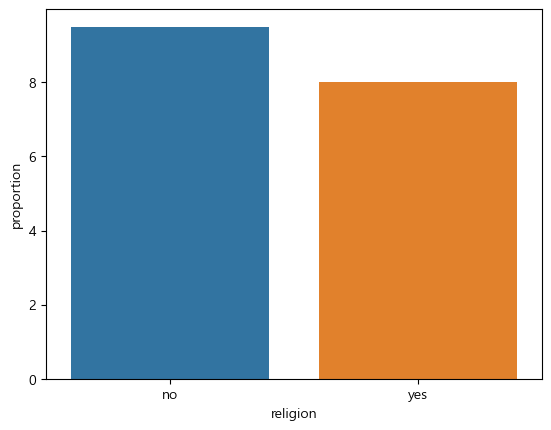

In [158]:
# 막대 그래프 만들기
sns.barplot(data=rel_div, x='religion', y='proportion')